In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import powerlaw
import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio

from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import  matplotlib.markers as mark

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

import os

In [2]:
# graphical properties
# sns.set_context('paper', font_scale=2.4)
# sns.set_context('talk',font_scale= 3.4)
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 7})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"

In [4]:
# paths
save_fig_path = '../figs/'

In [9]:
def sing_exp(x, a, t1):
    return a * np.exp(-x/t1) 

def sing_exp_oscil(x, a, t1, coef, phase):
    f = 2
    return a * (coef * np.exp(-x/t1)  + (1-coef) * np.sqrt(2)*np.sin(phase + 2* np.pi*0.001 * f * x))

def double_exp(x, a, b, t1, t2):
    return a * (1-b) * np.exp(-x/t1) + a * (b) * np.exp(-x/t2) 

In [10]:
def OU_gen(tau,D,deltaT,T,numTrials):
    numBin = int(T/deltaT)
    noise =  np.random.normal(loc=0,scale=1,size=(numTrials,numBin))
    x = np.zeros((numTrials,numBin))
    x[:,0] = noise[:,0]
    for iBin in range(1,numBin):
        x[:,iBin]  = x[:,iBin-1] - (x[:,iBin-1]/tau)*deltaT + np.sqrt(2*D*deltaT)*noise[:,iBin-1]        
    return x


def cc_withoutBinning(x1,x2, maxTimeLag, binSize, numBin):    
    numTr1 = np.shape(x1)[0]
    numTr2 = np.shape(x2)[0]
    
    if numTr1 != numTr2:
        raise Exception('numTr1 != numTr2')
    
    numBinLag = int(np.ceil( (maxTimeLag)/binSize )+1)
    ac = np.zeros((numBinLag))
    for tr in range(numTr1):
        xt1 = x1[tr]
        xt2 = x2[tr]
        for iLag in  range(0,numBinLag):            
            ind1 = np.arange(np.max([0,-iLag]),np.min([numBin-iLag,numBin]))  # index to take this part of the array 1
            ind2 = np.arange(np.max([0,iLag]),np.min([numBin+iLag,numBin]))  # index to take this part of the array 2
            ac[iLag] = ac[iLag]+(np.dot(xt1[ind1],xt2[ind2])/(len(ind1))-np.mean(xt1[ind1])*np.mean(xt2[ind2]))        
    return ac/numTr1

def cc_withoutBinning_globalTrialMean(x1,x2, maxTimeLag, binSize, numBin):    
    numTr1 = np.shape(x1)[0]
    numTr2 = np.shape(x2)[0]
    
    if numTr1 != numTr2:
        raise Exception('numTr1 != numTr2')
    
    numBinLag = int(np.ceil( (maxTimeLag)/binSize )+1)
    ac = np.zeros((numBinLag))
    for tr in range(numTr1):
        xt1 = x1[tr]
        xt2 = x2[tr]
        for iLag in  range(0,numBinLag):            
            ind1 = np.arange(np.max([0,-iLag]),np.min([numBin-iLag,numBin]))  # index to take this part of the array 1
            ind2 = np.arange(np.max([0,iLag]),np.min([numBin+iLag,numBin]))  # index to take this part of the array 2
            ac[iLag] = ac[iLag]+(np.dot(xt1[ind1],xt2[ind2])/(len(ind1))-np.mean(xt1)*np.mean(xt2))        
    return ac/numTr1

def spTospCount(spikes, new_shape):
    shape = (new_shape[0], spikes.shape[0] // new_shape[0],
             new_shape[1], spikes.shape[1] // new_shape[1])
    return spikes.reshape(shape).sum(-1).sum(1)




def singOU_oscil(tau, coef, deltaT, T, numTrials, f, maxTimeLag):
    v = 1
    D = v/tau
    deltaT = 1
    
    binSize = deltaT
    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1
    binsData =  np.arange(0, T , binSize)

    ou = OU_gen(tau,D,deltaT,T,numTrials)
    time_mat = np.tile(binsData, (numTrials,1))
    phases = np.random.rand(numTrials,1)* 2 * np.pi
    oscil = np.sqrt(2)*np.sin(phases + 2*np.pi*0.001*f* time_mat)
    data_syn = np.sqrt(1 - coeff) * oscil + np.sqrt(coeff) * ou   

    ac = cc_withoutBinning(data_syn, data_syn, maxTimeLag, binSize, numBinData)
    return(ac)
    
    
def singOU(tau, deltaT, T, numTrials, maxTimeLag):
    v = 1
    D = v/tau
    deltaT = 1
    
    binSize = deltaT
    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou = OU_gen(tau,D,deltaT,T,numTrials)
    ac = cc_withoutBinning(ou, ou, maxTimeLag, binSize, numBinData)
    return(ac)

def doubleOU(tau1, tau2, coeff, deltaT, T, numTrials, maxTimeLag):
    v = 1
    D1 = v/tau1 
    D2 = v/tau2
    deltaT = 1
    
    binSize = deltaT
    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)
    ou_all2 = OU_gen(tau2,D2,deltaT,T,numTrials)
    ou_all = np.sqrt(coeff) * ou_all1 + np.sqrt(1 - coeff) * ou_all2

    ac = cc_withoutBinning(ou_all,ou_all, maxTimeLag, binSize, numBinData)
    return(ac)

def singOU_oscil_spikes(tau, coef, a, b, deltaT, T, numTrials, f, maxTimeLag):
    v = 1
    D = v/tau
    deltaT = 1
    
    binSize = deltaT
    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1
    binsData =  np.arange(0, T , binSize)

    ou = OU_gen(tau,D,deltaT,T,numTrials)
    time_mat = np.tile(binsData, (numTrials,1))
    phases = np.random.rand(numTrials,1)* 2 * np.pi
    oscil = np.sqrt(2)*np.sin(phases + 2*np.pi*0.001*f* time_mat)
    data_syn = np.sqrt(1 - coeff) * oscil + np.sqrt(coeff) * ou  
    data_syn = a * data_syn + b
    data_syn[data_syn < 0] = 0

    spCounts_all = np.random.poisson(data_syn)
    ac = cc_withoutBinning(spCounts_all, spCounts_all, maxTimeLag, binSize, numBinData)
    return(ac)

def doubleSpikes(theta, T, numTrials, a, b, maxTimeLag, binSize):
    tau1 = np.array(theta[0])
    tau2 = np.array(theta[1])
    coeff = np.array(theta[2])

    v = 1
    D1 = v/tau1
    D2 = v/tau2
    deltaT = 1

    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)
    ou_all2 = OU_gen(tau2,D2,deltaT,T,numTrials)
    ou_all = np.sqrt(coeff) * ou_all1 + np.sqrt(1 - coeff) * ou_all2
    ou_check = np.max(ou_all)

    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

#     rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
    spCounts_all = np.random.poisson(ou_all)
    ac_syn = cc_withoutBinning(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)    
    return ac_syn


def doubleOU(theta, T, numTrials, a, b, maxTimeLag, binSize):
    tau1 = np.array(theta[0])
    tau2 = np.array(theta[1])
    coeff = np.array(theta[2])

    v = 1
    D1 = v/tau1
    D2 = v/tau2
    deltaT = 1

    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)
    ou_all2 = OU_gen(tau2,D2,deltaT,T,numTrials)
    ou_all = np.sqrt(coeff) * ou_all1 + np.sqrt(1 - coeff) * ou_all2
    ou_check = np.max(ou_all)

    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

    rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
    ac_syn = cc_withoutBinning(rate_sum,rate_sum, maxTimeLag, binSize, numBinData)    
    return ac_syn


def doubleSpikes_globalTrialMean(theta, T, numTrials, a, b, maxTimeLag, binSize):
    tau1 = np.array(theta[0])
    tau2 = np.array(theta[1])
    coeff = np.array(theta[2])

    v = 1
    D1 = v/tau1
    D2 = v/tau2
    deltaT = 1

    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)
    ou_all2 = OU_gen(tau2,D2,deltaT,T,numTrials)
    ou_all = np.sqrt(coeff) * ou_all1 + np.sqrt(1 - coeff) * ou_all2
    ou_check = np.max(ou_all)

    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

#     rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
    spCounts_all = np.random.poisson(ou_all)
    ac_syn = cc_withoutBinning_globalTrialMean(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)    
    return ac_syn

def singleSpikes(tau1, T, numTrials, a, b, maxTimeLag, binSize):
    v = 1
    D1 = v/tau1
    
    deltaT = 1

    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1
    
    ou_all = OU_gen(tau1,D1,deltaT,T,numTrials)

    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

    rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
    spCounts_all = np.random.poisson(rate_sum)
    ac_syn = cc_withoutBinning(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)    
    return ac_syn

def singleSpikes_globalTrialMean(tau1, T, numTrials, a, b, maxTimeLag, binSize):
    v = 1
    D1 = v/tau1
    
    deltaT = 1

    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1
    
    ou_all = OU_gen(tau1,D1,deltaT,T,numTrials)

    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

    rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
    spCounts_all = np.random.poisson(rate_sum)
    ac_syn = cc_withoutBinning_globalTrialMean(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)    
    return ac_syn


def singelSpikeGaus(tau1, T, numTrials, a, b, aa, maxTimeLag, binSize):
    v = 1
    D1 = v/tau1

    deltaT = 0.2
    
    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)

    ou_all = ou_all1
    ou_check = np.max(ou_all)
    if not np.isfinite(ou_check) or ou_check>10**10:
        return np.zeros(numBinData)
    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

    rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
#         spCounts_all = np.random.poisson(rate_sum)
    spCounts_all = Gaussian_sp(rate_sum,aa)
    ac_sp = cc_withoutBinning(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)
    return ac_sp

def singelSpikeGamma(tau1, T, numTrials, a, b, aa, maxTimeLag, binSize):
    v = 1
    D1 = v/tau1

    deltaT = 0.2
    
    binsData =  np.arange(0, T + binSize, binSize)
    numBinData = len(binsData)-1

    ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)

    ou_all = ou_all1
    ou_check = np.max(ou_all)
    if not np.isfinite(ou_check) or ou_check>10**10:
        return np.zeros(numBinData)
    ou_all = a * ou_all + b
    ou_all[ou_all < 0] = 0

    rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
#         spCounts_all = np.random.poisson(rate_sum)
    spCounts_all = gamma_sp(rate_sum,aa)
    ac_sp = cc_withoutBinning(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)
    return ac_sp

def doublelSpikeGaus(theta, T, numTrials, a, b, aa, maxTimeLag, binSize):
        tau1 = np.array(theta[0])
        tau2 = np.array(theta[1])
        coeff = np.array(theta[2])
        v = 1
        D1 = v/tau1
        D2 = v/tau2        
        binsData =  np.arange(0, T + binSize, binSize)
        numBinData = len(binsData)-1

        ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)
        ou_all2 = OU_gen(tau2,D2,deltaT,T,numTrials)
        ou_all = np.sqrt(coeff) * ou_all1 + np.sqrt(1 - coeff) * ou_all2  
        ou_check = np.max(ou_all)
        if not np.isfinite(ou_check) or ou_check>10**10:
            return np.zeros(maxTimeLag + 1)
        ou_all = a * ou_all + b
        ou_all[ou_all < 0] = 0

        rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
        spCounts_all = Gaussian_sp(rate_sum,aa)
        ac_sp = cc_withoutBinning(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)
        return ac_sp
    
def doublelSpikeGamma(theta, T, numTrials, a, b, aa, maxTimeLag, binSize):
        tau1 = np.array(theta[0])
        tau2 = np.array(theta[1])
        coeff = np.array(theta[2])
        v = 1
        D1 = v/tau1
        D2 = v/tau2        
        binsData =  np.arange(0, T + binSize, binSize)
        numBinData = len(binsData)-1

        ou_all1 = OU_gen(tau1,D1,deltaT,T,numTrials)
        ou_all2 = OU_gen(tau2,D2,deltaT,T,numTrials)
        ou_all = np.sqrt(coeff) * ou_all1 + np.sqrt(1 - coeff) * ou_all2  
        ou_check = np.max(ou_all)
        if not np.isfinite(ou_check) or ou_check>10**10:
            return np.zeros(maxTimeLag + 1)
        ou_all = a * ou_all + b
        ou_all[ou_all < 0] = 0

        rate_sum = spTospCount(ou_all, [numTrials,numBinData]) * deltaT
        spCounts_all = gamma_sp(rate_sum,aa)
        ac_sp = cc_withoutBinning(spCounts_all,spCounts_all, maxTimeLag, binSize, numBinData)
        return ac_sp

def double_exp(x, a, b, t1, t2):
    return a * (1-b) * np.exp(-x/t1) + a * (b) * np.exp(-x/t2) 

def sing_exp(x, a, t1):
    return a * np.exp(-x/t1) 

def gamma_sp(rate, coef):
#     spCounts_G = np.zeros(rate.shape)
    m = rate
    v = coef * rate
    theta = v/m
    k = m**2/v
    where_are_NaNs = np.isnan(k)
    k[where_are_NaNs] = 1
    theta[where_are_NaNs] = 1
    spCounts_G = np.random.gamma(shape = k, scale=theta)
    spCounts_G[where_are_NaNs] = 0
#     spCounts_G = np.round(spCounts_G)
    return spCounts_G

def Gaussian_sp(rate, coef):
    spCounts_G = np.zeros(rate.shape)
    for tr in range(len(rate)):
        spCounts_G[tr] = np.random.normal(loc = rate[tr],scale = np.sqrt(coef * rate[tr]))
    return spCounts_G


In [11]:
#-----------------FUNCTIONS FOR SMOOTHING SNAPSHOTS--------------------------#

def onedim_to_twodim(k,m,n):
    i = k // m + 1 - 1
    j = k % m 
    return i,j


def twodim_to_onedim (i,j,m,n):
    i = i + 1
    j = j +1
    k = (i-1) * n + j -1 
    return k

def find_nth_neigh_general (k,m,n,nth):
    i,j = onedim_to_twodim(k,m,n)
    
    i_up_all = []
    i_down_all = []
    for ct in (np.arange(nth)+1):
        i_up = int(i-ct >= 0) * (i-ct) + (m-(ct-i)) * int(i-ct < 0)
        i_down = int(i+ct <= m-1) * (i+ct) + (ct - ((m-1)-i)-1) * int(i+ct > m-1)
        i_up_all.append(i_up)
        i_down_all.append(i_down)
        
    j_left_all = []
    j_right_all = []
    for ct in (np.arange(nth)+1):
        j_left = int(j-ct >= 0) * (j-ct) + (n-(ct-j)) * int(j-ct < 0)
        j_right = int(j+ct <= n-1) * (j+ct) + (ct - ((n-1)-j)-1) * int(j+ct > n-1)
        j_left_all.append(j_left)
        j_right_all.append(j_right)
        
    x = [i_up_all[-1]]*(2*nth+1)
    y = [i_down_all[-1]]*(2*nth+1)
    z = i_up_all[:-1] + [i] + i_down_all[:-1] 
    NB_i = np.array(x + y + z +z)
    
    xx = [j_right_all[-1]]*(2*nth-1)
    yy = [j_left_all[-1]]*(2*nth-1)
    zz = j_left_all + [j] + j_right_all 
    NB_j = np.array(zz + zz + xx + yy)
    NB = twodim_to_onedim (NB_i,NB_j,m,n)
    return NB


def find_allneigh_smoothing(n,m,num_neigh):
    num_cell = n*m
    neigh_all = []
    for i in range(num_cell):
        temp_NB = [i] #add each self in its list
        for j in range(num_neigh):
            NB = find_nth_neigh_general(i,m,n,j+1)
            temp_NB.extend(NB)
        neigh_all.append(temp_NB)
    return neigh_all

def smooth_snapshot(s,k,neigh_all,threshold):
    s_new = np.int(np.sum(s[neigh_all[k]])>threshold)
    return s_new


def plot_comparison_total_withKDE(tau1_1, tau2_1, coef_1, label1, color1, tau1_2, tau2_2, coef_2 , label2, color2 ,a):     
        
    fig = plt.figure(figsize=(18,4))
    fs = 22

    index = 1
    plt.subplot(1,2,index)
    weights = np.ones_like(tau1_1)/float(len(tau1_1))
    plt.hist(tau1_1, bins = np.arange(0,31,1), facecolor= color1, density=True,  alpha=a);

    weights = np.ones_like(tau1_2)/float(len(tau1_2))
    plt.hist(tau1_2, bins = np.arange(0,31,1), facecolor= color2, density=True,  alpha=a);
    
    sns.kdeplot(tau1_1, data2=None, shade=False, vertical=False, kernel='gau', color = color1)
    sns.kdeplot(tau1_2, data2=None, shade=False, vertical=False, kernel='gau', color = color2)

    plt.axvline(u11, ls="--",color='gray')
    plt.axvline(u12, ls="--",color='gray')
    plt.xlabel(r"$\tau_1$", fontsize=fs)
    plt.ylabel('probability', fontsize=fs)

    plt.subplot(1,2,index+1)
    weights = np.ones_like(tau2_1)/float(len(tau2_1))
    plt.hist(tau2_1, np.arange(0,200,6), facecolor= color1, density=True,  alpha=a);

    weights = np.ones_like(tau2_2)/float(len(tau2_2))
    plt.hist(tau2_2, np.arange(0,200,6), facecolor= color2, density=True,  alpha=a);
    
    sns.kdeplot(tau2_1, data2=None, shade=False, vertical=False, kernel='gau', color = color1)
    sns.kdeplot(tau2_2, data2=None, shade=False, vertical=False, kernel='gau', color = color2)
    
    plt.axvline(u21, ls="--",color='gray')
    plt.axvline(u22, ls="--",color='gray')
    plt.xlabel(r"$\tau_2$", fontsize=fs)
    # # sns.kdeplot(tau2, data2=None, shade=False, vertical=False, kernel='gau', color ='b')


    fig.tight_layout()
    

# synthetic data

In [12]:
T = 1000
binSize = 1
v = 1
tau1 = 40
D1 = v/tau1
numTrials = 10

deltaT = 0.2

binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1

ou_all = OU_gen(tau1,D1,deltaT,T,numTrials)

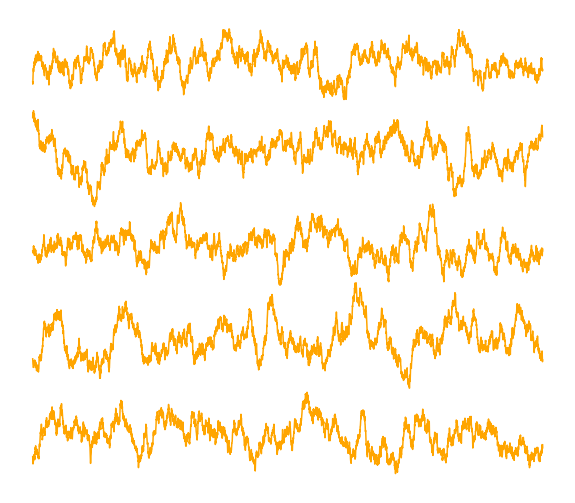

In [22]:
fig = plt.figure(figsize = (8,7))
cm = 1/2.54  # centimeters in inches
# fig = plt.figure(figsize=(3*cm, 2*cm))
ax = plt.subplot(111)
jump = 6
for i in range(5):
    plt.plot(ou_all[i]+i*jump, color = 'orange')   
# Hide axis
ax.axis('off')

    
fig.tight_layout()
plt.savefig(save_fig_path+'fig2_1.pdf',bbox_inches='tight')

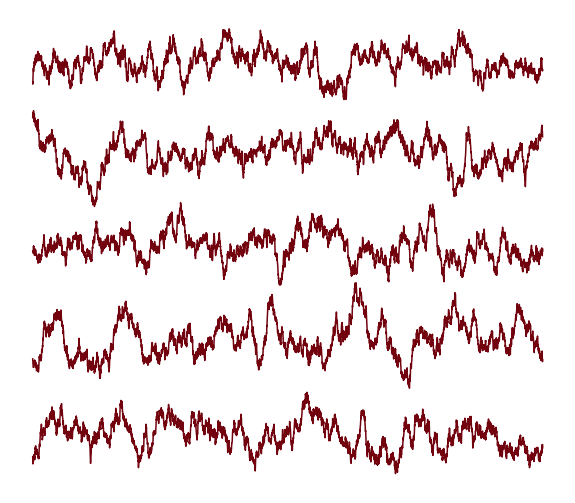

In [14]:
T = 1000
binSize = 1
v = 1
tau1 = 20
D1 = v/tau1
numTrials = 5

deltaT = 0.2

binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1

ou_all = OU_gen(tau1,D1,deltaT,T,numTrials)

fig = plt.figure(figsize = (8,7))
ax = plt.subplot(111)
jump = 6
for i in range(5):
    plt.plot(ou_all[i]+i*jump, color = plt.cm.Reds(250))   
# Hide axis
ax.axis('off')

    
fig.tight_layout()
plt.savefig(save_fig_path+'fig2_2.pdf',bbox_inches='tight')

# AC shapes

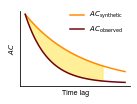

In [29]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(5*cm, 3.5*cm))
ax = plt.subplot(111)
f = 7
fleg = 7

t = np.arange(0,90)

plt.plot(t, np.exp(-t/50), lw = 1.5, color = 'darkorange', label = r'$AC_\mathrm{synthetic}$')
plt.plot(t, np.exp(-t/20), lw = 1.5, color = plt.cm.Reds(250), label = r'$AC_\mathrm{observed}$')

t = np.arange(0,70)
y2 = np.exp(-t/50) 
y1 = np.exp(-t/20)
ax.fill_between(t,y2, y1, color = 'gold',alpha = 0.4)

plt.ylabel(r'$AC$',fontsize=f)
plt.xlabel('Time lag',fontsize=f)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# hide ticks
plt.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False, labelleft=False)

plt.legend(frameon = False, fontsize = fleg, loc = 'upper right', bbox_to_anchor=(1.,1.1))

plt.savefig(save_fig_path+'fig2_3.pdf',bbox_inches='tight')

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


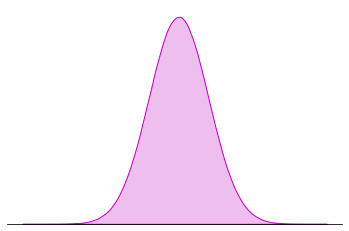

In [24]:
cm = 1/2.54  # centimeters in inches
# fig = plt.figure(figsize=(2*cm, 2*cm))

ax = plt.subplot(111)
s = np.random.normal(loc = 0, scale = 300, size=5000000)
# plt.hist(s, density=True)
sns.kdeplot(s, data2=None, shade=True, vertical=False, kernel='gau', color = 'm')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# hide ticks
plt.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False, labelleft=False)
plt.ylabel('')
plt.savefig(save_fig_path+'fig2_4.pdf',bbox_inches='tight')

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


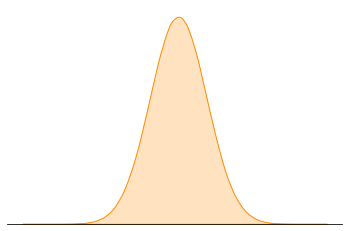

In [19]:
ax = plt.subplot(111)
s = np.random.normal(loc = 0, scale = 300, size=5000000)
# plt.hist(s, density=True)
sns.kdeplot(s, data2=None, shade=True, vertical=False, kernel='gau', color = 'darkorange')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# hide ticks
plt.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False, labelleft=False)
plt.ylabel('')
plt.savefig(save_fig_path+'fig2_5.pdf',bbox_inches='tight')